# **1. Obtendo o dataset**

O dataset utilizado foi encontrado no Kaggle sob o link: https://www.kaggle.com/grassknoted/asl-alphabet.

Utilizamos para download dos dados em Google Colaboratory o seguinte tutorial: https://www.kaggle.com/discussions/general/74235

In [1]:
#instalação da biblioteca do Kaggle
! pip install -q kaggle

#Download do token da API
!gdown 'https://drive.google.com/uc?id=16nwgUAiGou9KeU_4_a54Xj4HHp0l2Gvz'

#Criação do diretório para o token
! mkdir ~/.kaggle

#Transferência do arquivo para o diretório
! cp kaggle.json ~/.kaggle/

#Autorização do arquivo
! chmod 600 ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=16nwgUAiGou9KeU_4_a54Xj4HHp0l2Gvz
To: /content/kaggle.json
100% 68.0/68.0 [00:00<00:00, 184kB/s]


In [5]:
#Download do dataset

#Conferir se ambos os progressos foram 100%, senão, rodar de novo
! kaggle datasets download -d grassknoted/asl-alphabet --force

100% 1.02G/1.03G [00:04<00:00, 197MB/s]
100% 1.03G/1.03G [00:04<00:00, 230MB/s]


In [6]:
#Criação do diretório onde serão descompactados os dados
! mkdir ASL

#Descompactação dos dados
! unzip asl-alphabet.zip -d ASL

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: ASL/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: ASL/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: ASL/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: ASL/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: ASL/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: ASL/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: ASL/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: ASL/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: ASL/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: ASL/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: ASL/asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: ASL/asl_alphabet_train/asl_alphabet_trai

# **2. Preprocessamento dos dados e visualização**

## **Importação das bibliotecas**

In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [8]:
# Listagem dos caminhos dos arquivos
dir_ = Path('/content/ASL/asl_alphabet_train')
file_paths = list(dir_.glob(r'**/*.jpg'))

In [11]:
# Criação de um DataFrame com os caminhos e labels das figuras

def proc_img(filepath):

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name = 'Filepath').astype(str)
    labels = pd.Series(labels, name = 'Label')

    # Concatenação de caminhos e labels
    df = pd.concat([filepath, labels], axis = 1)

    # Aleatorização do DataFrame e reconfiguração dos indices
    df = df.sample(frac = 1, random_state = 0).reset_index(drop = True)

    return df

df = proc_img(file_paths)

print(f'Número de imagens no dataset: {df.shape[0]}\n')
print(f'Número de labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

#Exibição do Dataframe
df.head(5)

Número de imagens no dataset: 87000

Número de labels: 29

Labels: ['nothing' 'J' 'H' 'T' 'V' 'K' 'A' 'X' 'R' 'U' 'E' 'D' 'G' 'space' 'Q' 'Y'
 'I' 'Z' 'P' 'O' 'W' 'L' 'C' 'S' 'B' 'N' 'M' 'F' 'del']


,Filepath,Label
0,/content/ASL/asl_alphabet_train/asl_alphabet_t...,nothing
1,/content/ASL/asl_alphabet_train/asl_alphabet_t...,J
2,/content/ASL/asl_alphabet_train/asl_alphabet_t...,H
3,/content/ASL/asl_alphabet_train/asl_alphabet_t...,T
4,/content/ASL/asl_alphabet_train/asl_alphabet_t...,V


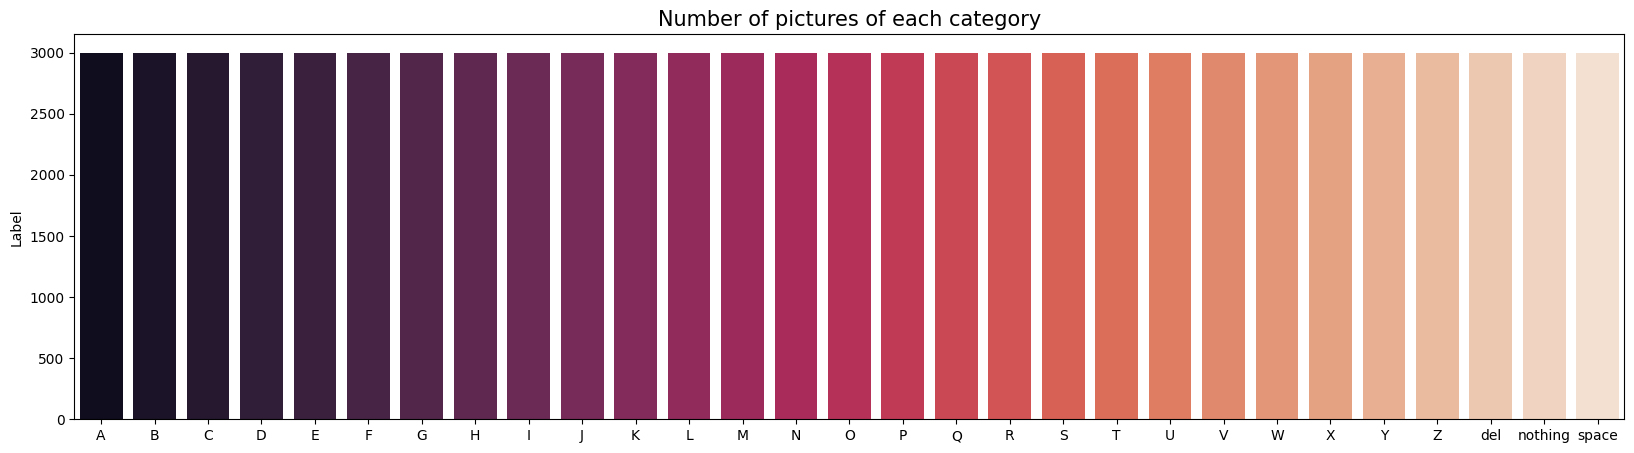

In [12]:
# Visualização do número de imagens por categoria
vc = df['Label'].value_counts()
plt.figure(figsize = (20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

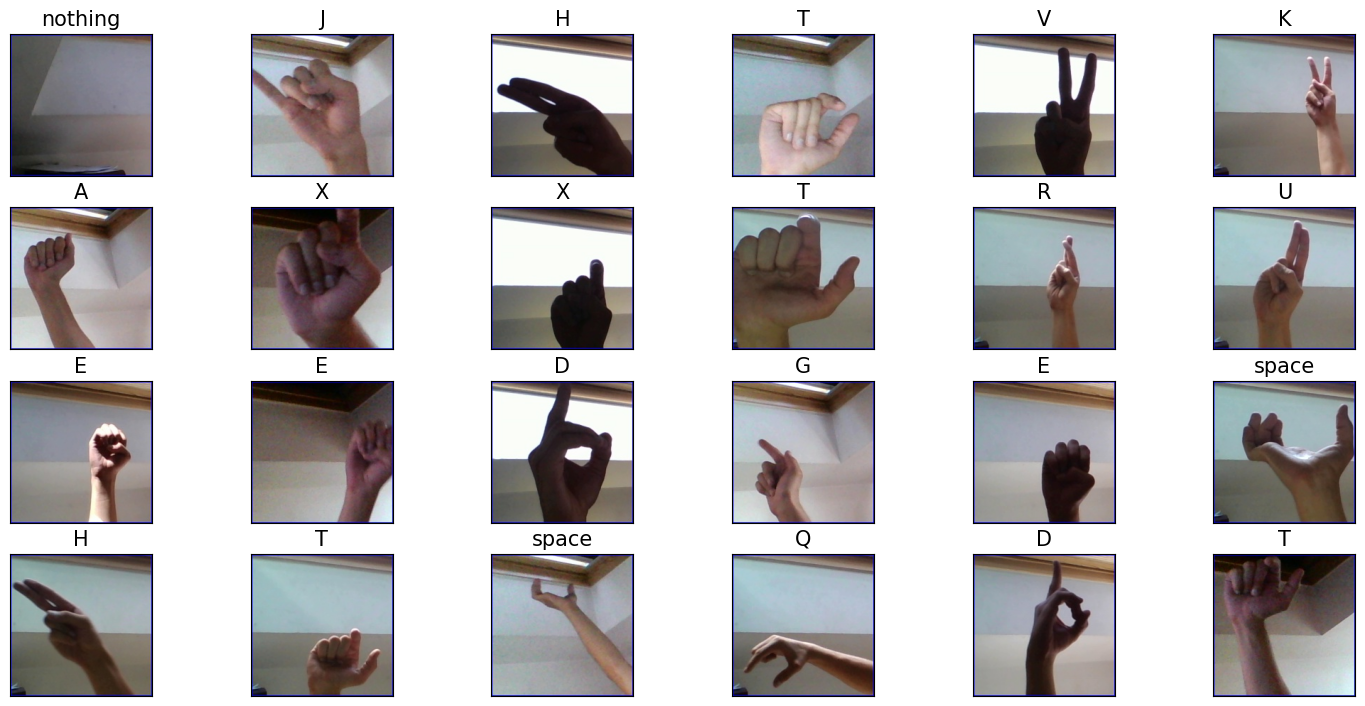

In [13]:
# Visualização de algumas imagens do Dataset
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (15, 7),
                         subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 15)
plt.tight_layout(pad = 0.5)
plt.show()

# **3. Load the Images with a generator and Data Augmentation**

In [15]:
def create_gen():
    # Carrega as imagens e aplica Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split = 0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe = train_df,
        x_col = 'Filepath',
        y_col = 'Label',
        target_size = (224, 224),
        color_mode = 'rgb',
        class_mode = 'categorical',
        batch_size = 32,
        shuffle = True,
        seed = 0,
        subset = 'training',
        rotation_range = 30,
        zoom_range = 0.15,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.15,
        horizontal_flip = True,
        fill_mode = "nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe = train_df,
        x_col = 'Filepath',
        y_col = 'Label',
        target_size = (224, 224),
        color_mode = 'rgb',
        class_mode = 'categorical',
        batch_size = 32,
        shuffle = True,
        seed = 0,
        subset = 'validation',
        rotation_range = 30,
        zoom_range = 0.15,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.15,
        horizontal_flip = True,
        fill_mode = "nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe = test_df,
        x_col = 'Filepath',
        y_col = 'Label',
        target_size = (224, 224),
        color_mode = 'rgb',
        class_mode = 'categorical',
        batch_size = 32,
        shuffle = False
    )

    return train_generator, test_generator, train_images, val_images, test_images

# **4. Train the architecture with the best result**

In [16]:
def get_and_compile_model(model_class):
# Configuração e carregamento do modelo
    kwargs = {
        'input_shape': (224, 224, 3),
        'include_top': False,
        'weights': 'imagenet',
        'pooling': 'avg'
    }

    pretrained_model = model_class(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation = 'relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation = 'relu')(x)
    outputs = tf.keras.layers.Dense(29, activation = 'softmax')(x)

    model = tf.keras.Model(inputs = inputs, outputs = outputs)

    optimizer = tf.keras.optimizers.Adam(
        learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)

    model.compile(
        optimizer = optimizer,
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

In [ ]:
# Divisão do dataset em treino e teste
train_df, test_df = train_test_split(df, test_size = 0.1, random_state = 0)

# Cria os geradores
train_generator, test_generator, train_images, val_images, test_images = create_gen()

# Cria o modelo
model = get_and_compile_model( eval("tf.keras.applications.MobileNet") )

# Treina o modelo
history = model.fit(train_images,
                    validation_data = val_images,
                    epochs = 5,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(
                            monitor = 'val_loss',
                            patience = 1,
                            verbose = 1,
                            restore_best_weights = True)]
                    )

# Salva o modelo
model.save('Best_Pretrained_Model_ASL_Alphabet.h5')
print('Model Saved!')

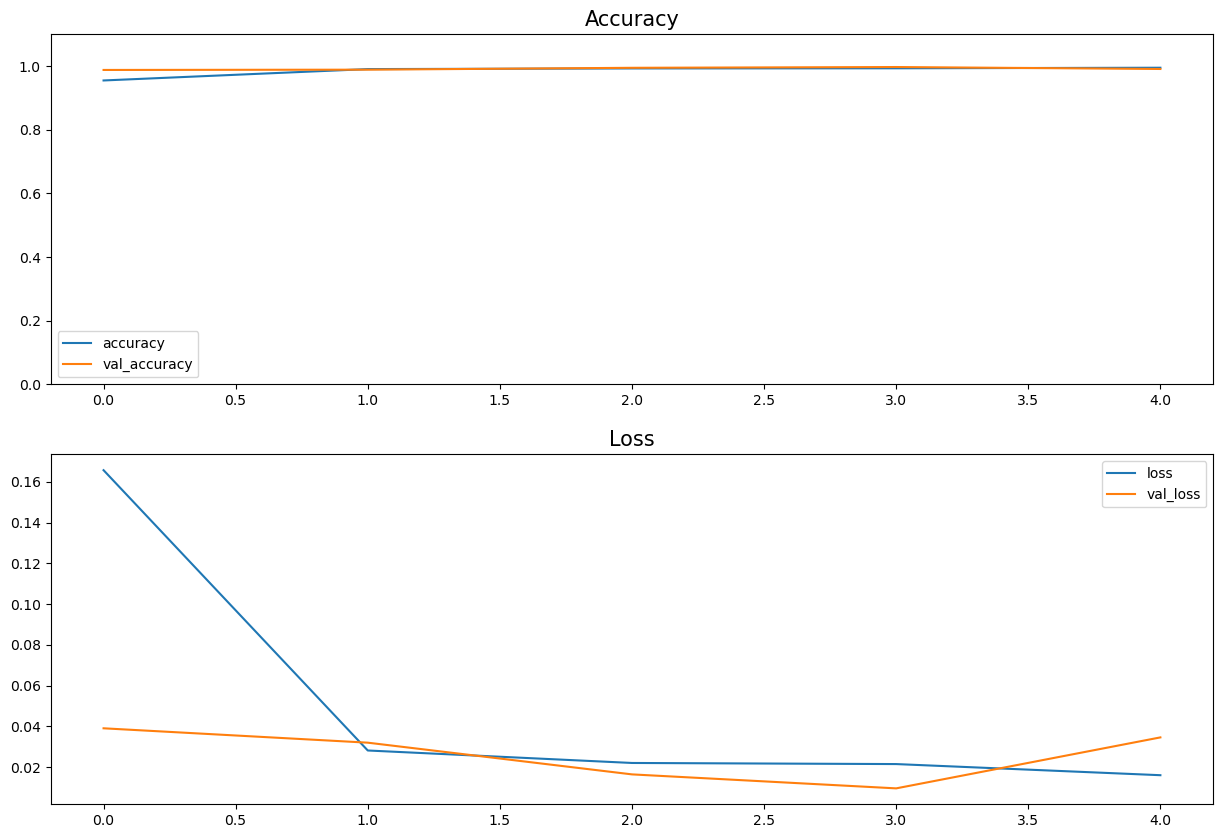

In [ ]:
#visualização de loss e acurácia

fig, axes = plt.subplots(2, 1, figsize = (15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(ax = ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0, 1.1)

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax = ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

272/272 [==============================] - 76s 278ms/step
## Best Model: MobileNet with 99.54% accuracy on the test set


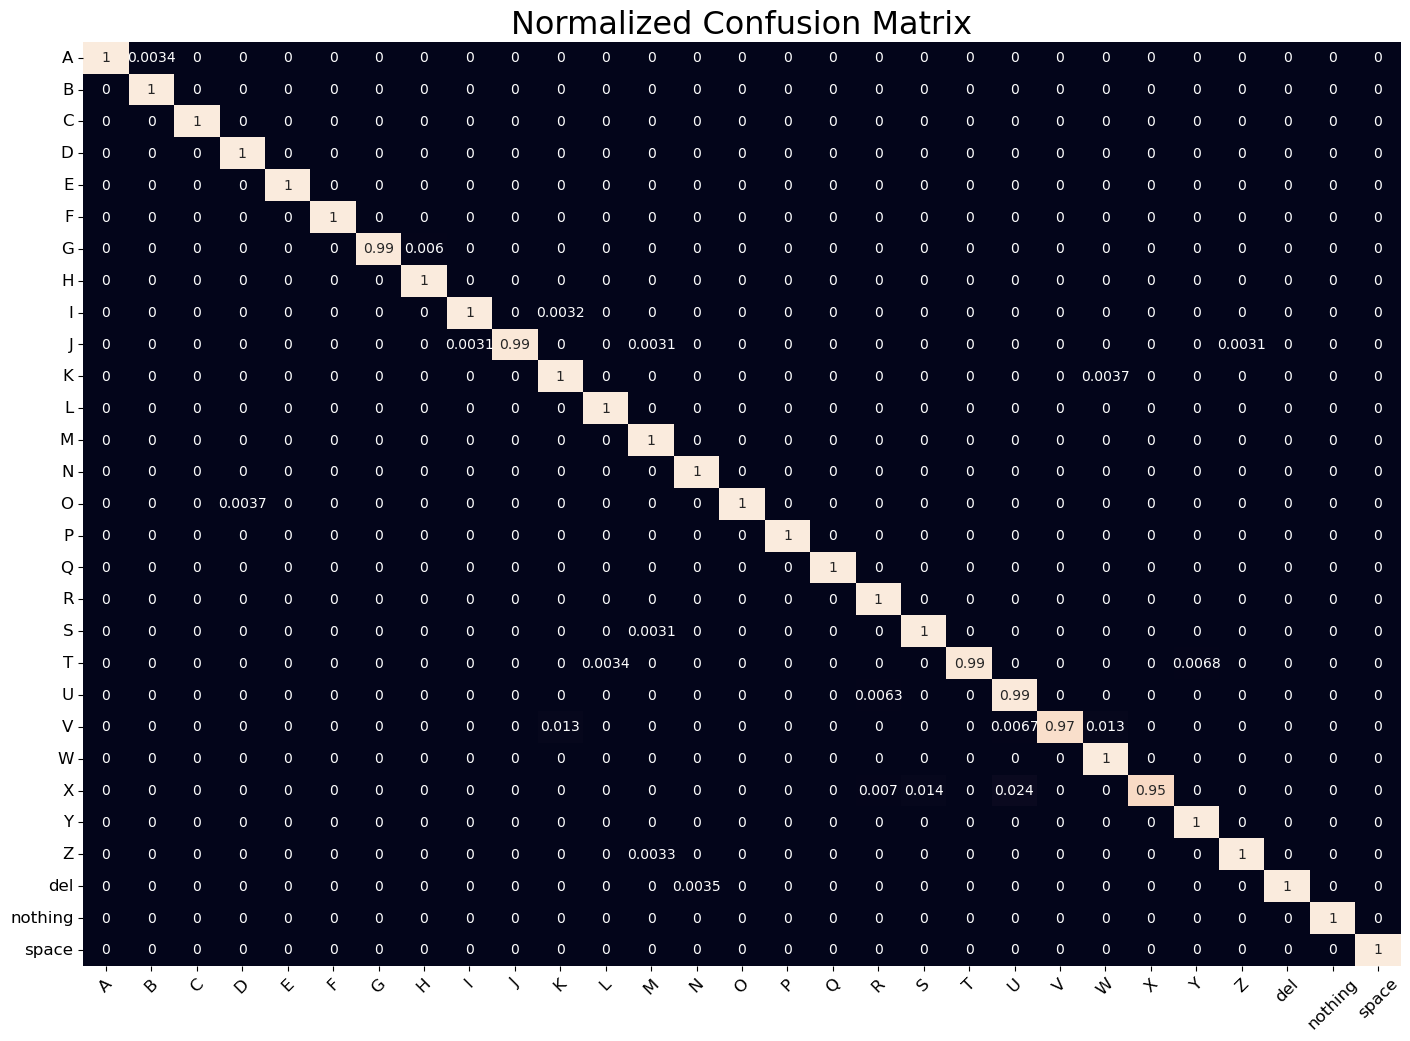

In [ ]:
# Predição das labels
pred = model.predict(test_images)
pred = np.argmax(pred, axis = 1)

# Mapeamento das labels
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred = [labels[k] for k in pred]

# Acurácia no Dataset de teste
y_test = list(test_df.Label)
acc = accuracy_score(y_test, pred)

# Print do resultado
print(f'## Best Model: {best_model[0]} with {acc*100:.2f}% accuracy on the test set \n\n')

# Visualização da Matriz de confusão
cf_matrix = confusion_matrix(y_test, pred, normalize = 'true')
plt.figure(figsize = (17, 12))
sns.heatmap(cf_matrix, annot = True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)), cbar = False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize = 12,rotation = 45)
plt.yticks(fontsize = 12)
plt.show()

# **5. Examples of prediction**

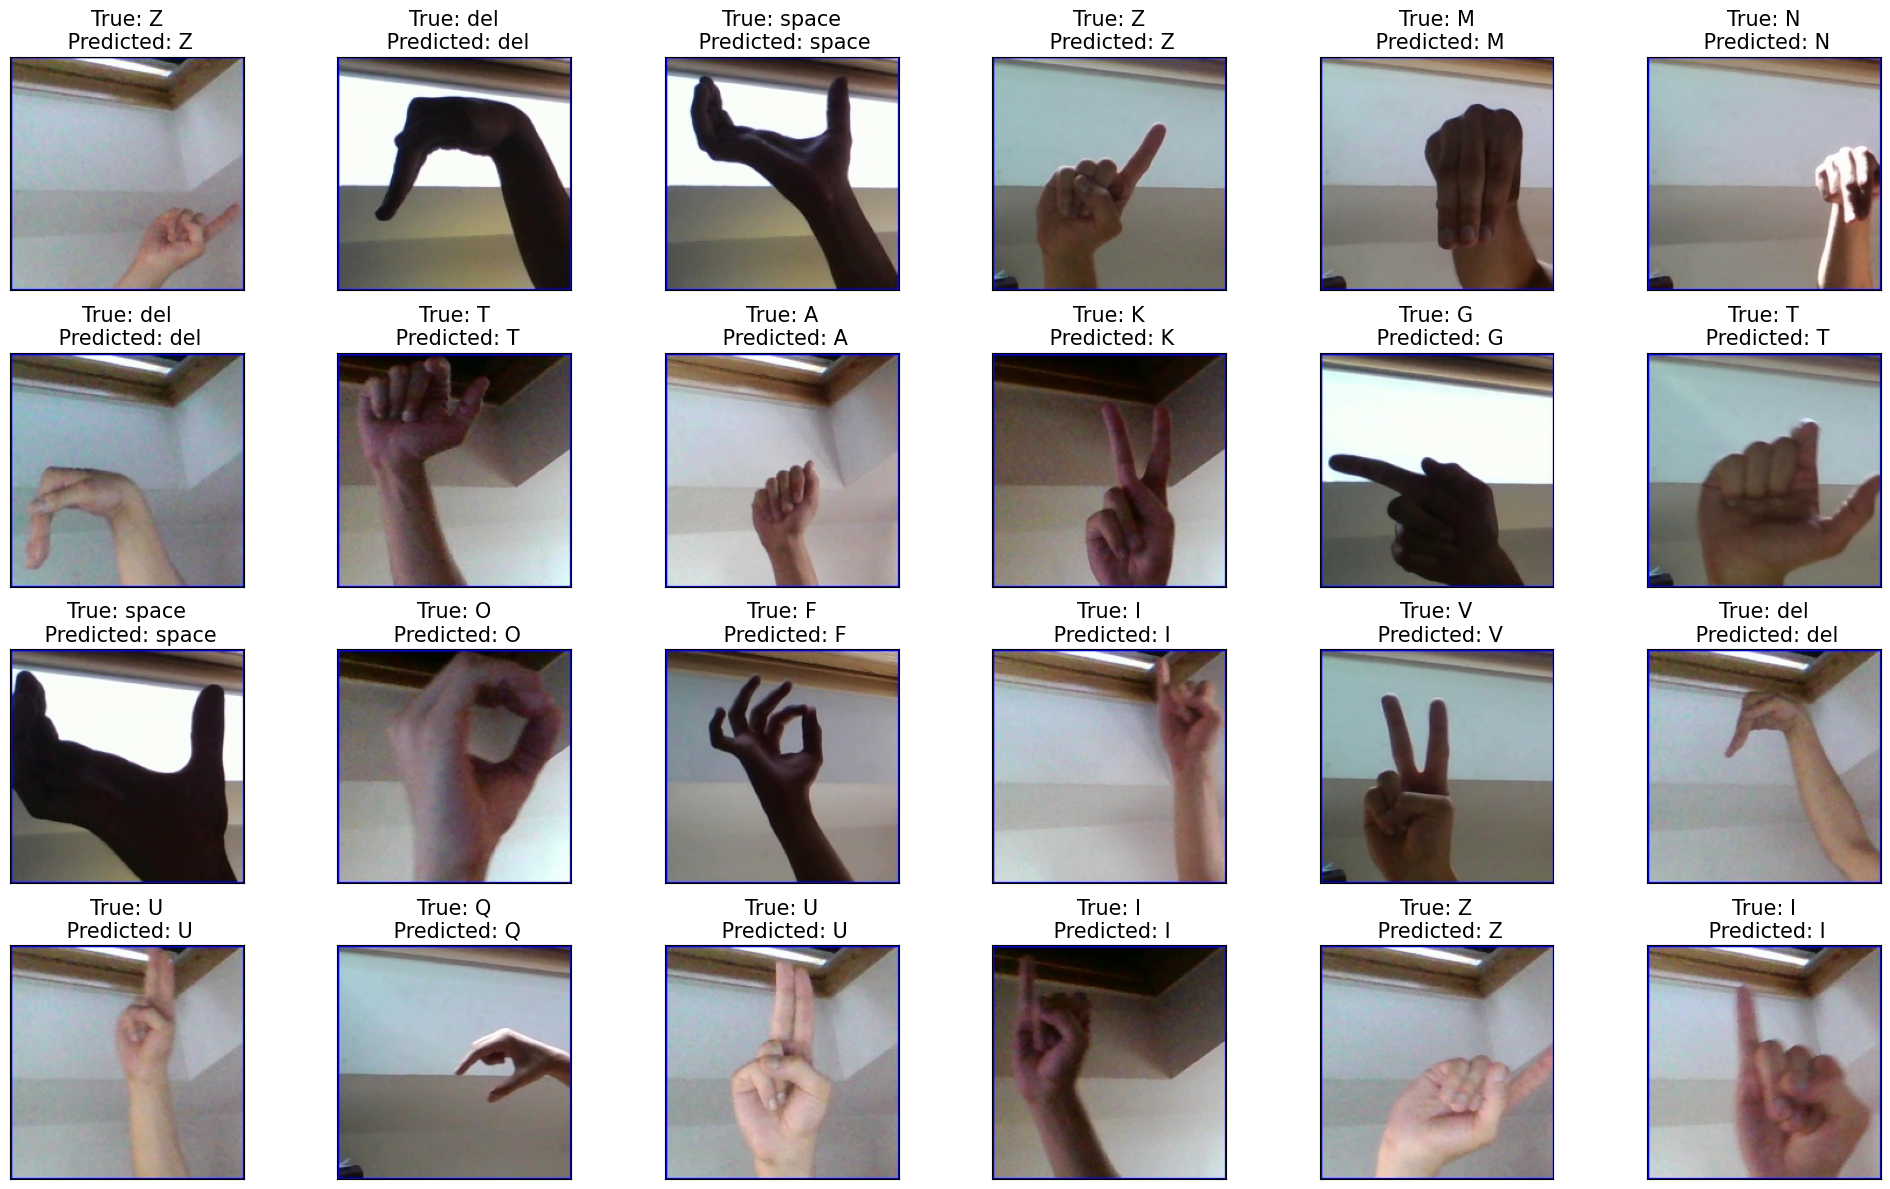

In [ ]:
# Exibição de imagens com suas labels e predições
fig, axes = plt.subplots(nrows = 4, ncols = 6, figsize = (20, 12),
                        subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"Verdadeira: {test_df.Label.iloc[i].split('_')[0]}\n Predita: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()